In [10]:
from IPython.display import Math
import pandas as pd
import scipy.stats as sts
import pystan
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['figure.dpi'] = 120
sns.set_context("paper", font_scale=1.5)

# Visualizing data

In [2]:
df = pd.read_csv("dataset_rho4.csv")
df.sample(n=10)

,L,eta,phi
89,3.162278,0.9,0.958316
2025,50.000000,0.3,0.992667
1234,10.000000,2.4,0.667209
1536,31.622777,0.4,0.985689
1209,10.000000,2.1,0.710229
1610,31.622777,1.2,0.880096
1017,10.000000,0.2,0.997265
1122,10.000000,1.3,0.883388
50,3.162278,0.6,0.982522
443,3.162278,4.5,0.218409


In [3]:
Math("$L \\in \\{{{}\\}}$".format(", ".join(df.L.unique().round(2).astype(str))))

<IPython.core.display.Math object>

In [4]:
Math("$\\eta \\in \\{{{}\\}}$".format(", ".join(df.eta.unique().round(2).astype(str))))

<IPython.core.display.Math object>

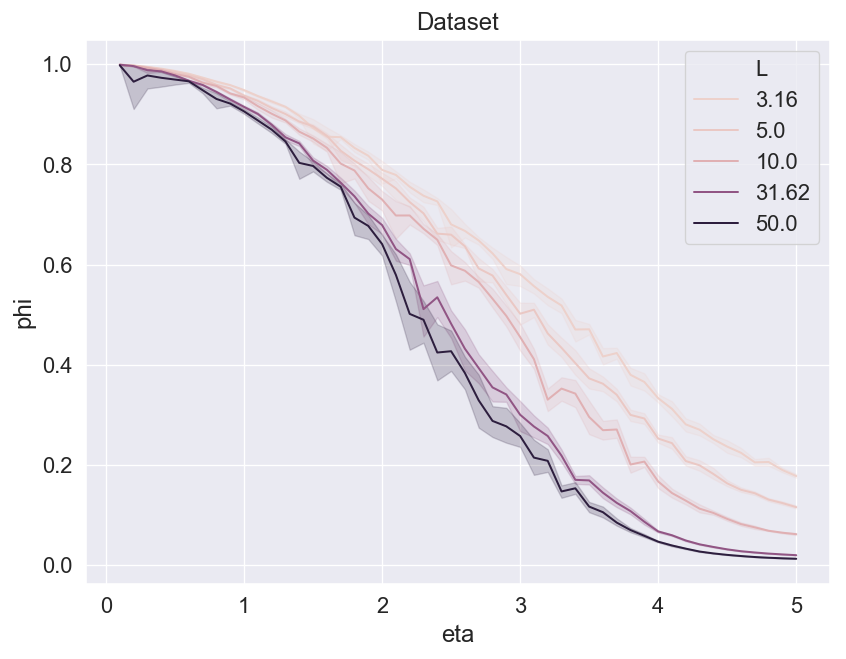

In [13]:
temp_df = df.copy()
temp_df["L"] = temp_df["L"].round(2)
ax = sns.lineplot(x="eta", y="phi", hue="L", data=temp_df, legend="full")
plt.title("Dataset")
plt.savefig("dataset.png")
plt.show()

# Visualizing prior for critical exponents $\beta$ and $\nu$

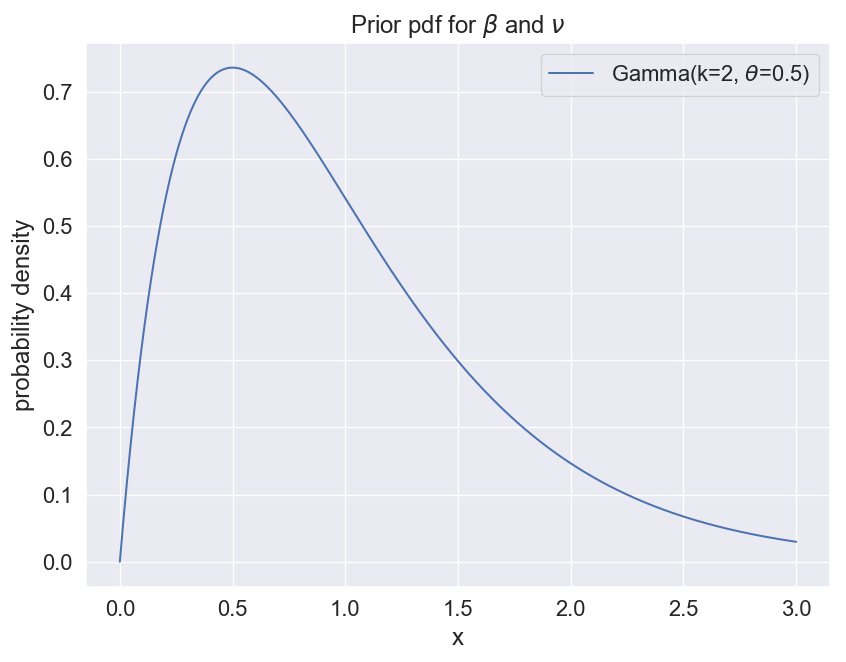

In [12]:
plt.figure()
x = np.linspace(0, 3.0, 10000)
k=2.
theta = 0.5
plt.plot(x, sts.gamma.pdf(x, k, scale=theta), label=r"Gamma(k=2, $\theta$=0.5)")
plt.legend()
plt.title(r"Prior pdf for $\beta$ and $\nu$")
plt.xlabel("x")
plt.ylabel("probability density")
plt.savefig("prior1.png")
plt.show()

# Prior for $\eta_c(\infty)$

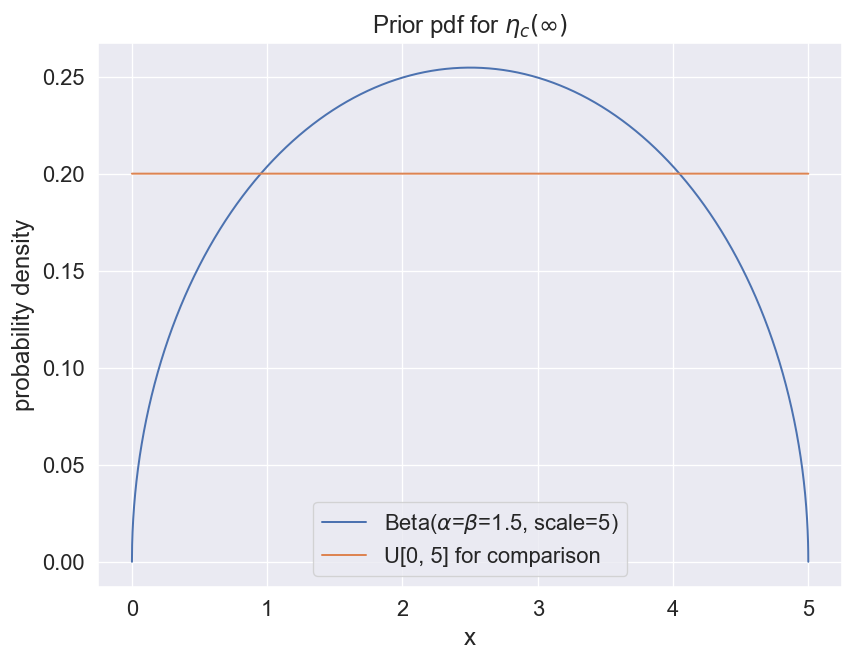

In [14]:
plt.figure()
x = np.linspace(0, 5.0, 10000)
alpha = 1.5
beta = 1.5
scale = 5.
plt.plot(x, sts.beta.pdf(x, alpha, beta, scale=scale), label=r"Beta($\alpha$=$\beta$=1.5, scale=5)")
plt.plot(x, sts.beta.pdf(x, 1., 1., scale=scale), label="U[0, 5] for comparison")
plt.legend()
plt.title(r"Prior pdf for $\eta_c(\infty)$")
plt.xlabel("x")
plt.ylabel("probability density")
plt.savefig("prior2.png")
plt.show()

# Prior for $\sigma$

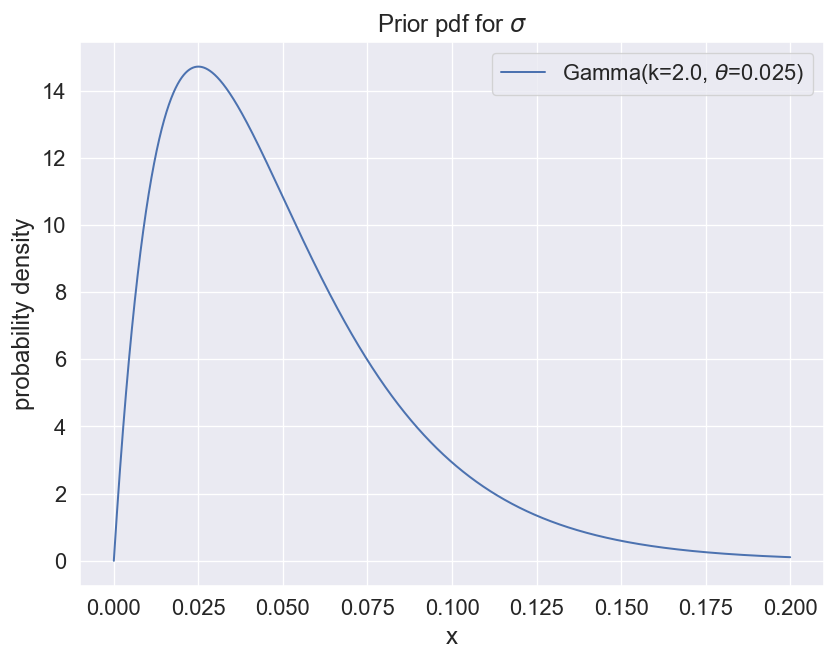

In [15]:
plt.figure()
x = np.linspace(0, 0.2, 10000)
theta = 0.025
k=0.05/theta
plt.plot(x, sts.gamma.pdf(x, k, scale=theta), label=r"Gamma(k={}, $\theta$={})".format(k, theta))
plt.legend()
plt.title(r"Prior pdf for $\sigma$")
plt.xlabel("x")
plt.ylabel("probability density")
plt.savefig("prior3.png")
plt.show()

# Generate fake data

In [121]:
def plot_fake_data(num): 
    # Sampling the top-level parameters
    beta = sts.gamma.rvs(2., scale=0.5)
    nu = sts.gamma.rvs(2., scale=0.5)
    eta_c_inf = sts.beta.rvs(1.5, 1.5, scale=5)
    sigma = sts.gamma.rvs(2., scale=0.025)
    k = np.random.random()*100
    
    # Empty arrays to store generated fake data
    Ls = np.zeros(len(df))
    etas = np.zeros(len(df))
    phis = np.zeros(len(df))
    
    count = 0
    # Imitate the simulation experiment: iterating through 
    # the same L's and eta's as in the original dataset
    for L in df["L"].unique():
        # Calculate the critical noise for system of size L
        eta_c_L = eta_c_inf + k * L**(-1./nu)
        for eta in df["eta"].unique():
            # If noise does not exceed critical noise
            if eta_c_L - eta > 0:
                phi0 = ((eta_c_L - eta)/eta_c_L)**beta
            else:# otherwise order=0
                phi0 = 0
            # Imitate the 10 trials
            for each_trial in range(10):
                Ls[count] = L
                etas[count] = eta
                phis[count] = sts.norm.rvs(phi0, sigma)
                count += 1

    plot_df = pd.DataFrame({"phi": phis, "eta": etas, "L": Ls})
    temp_df = plot_df.copy()
    temp_df["L"] = temp_df["L"].round(2)
    ax = sns.lineplot(x="eta", y="phi", hue="L", data=temp_df, legend="full")
    plt.title("Fake data {}".format(num))
    plt.savefig("fakedata{}.png".format(num))
    plt.show()

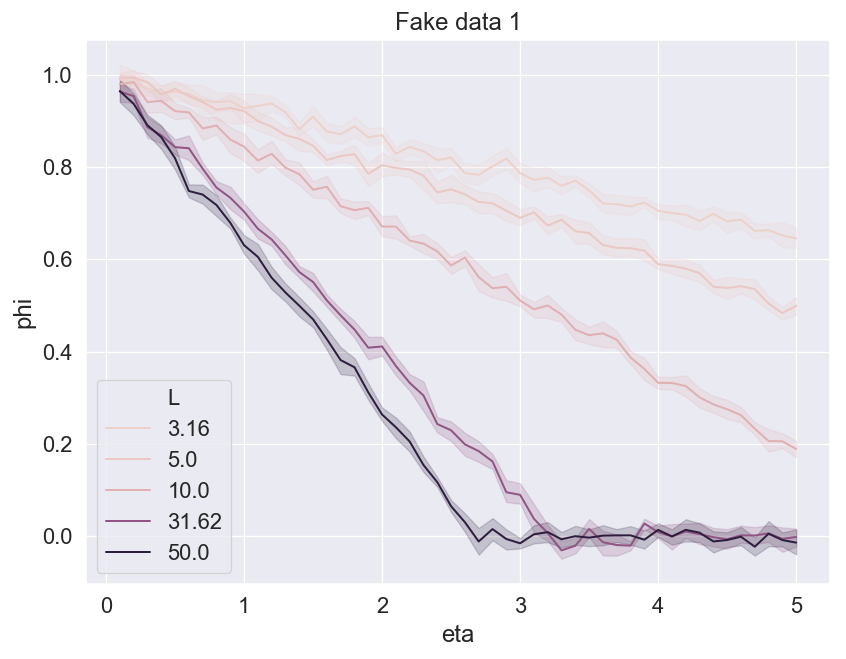

In [122]:
plot_fake_data(1)

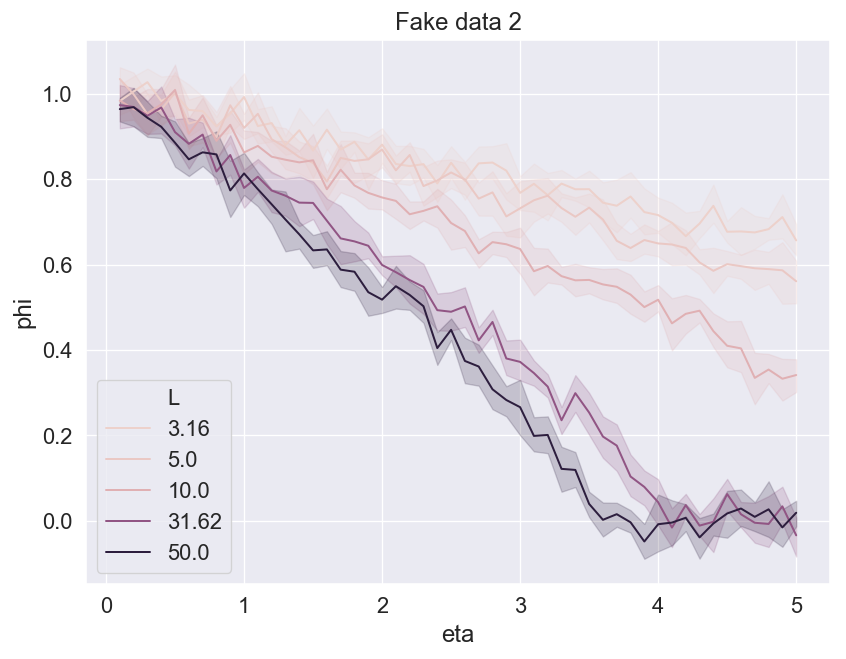

In [123]:
plot_fake_data(2)

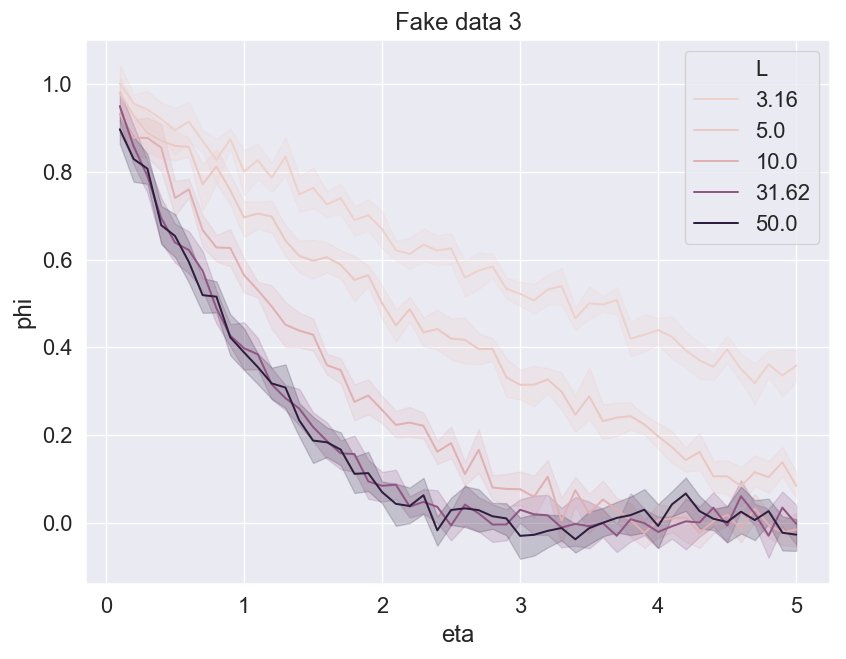

In [124]:
plot_fake_data(3)

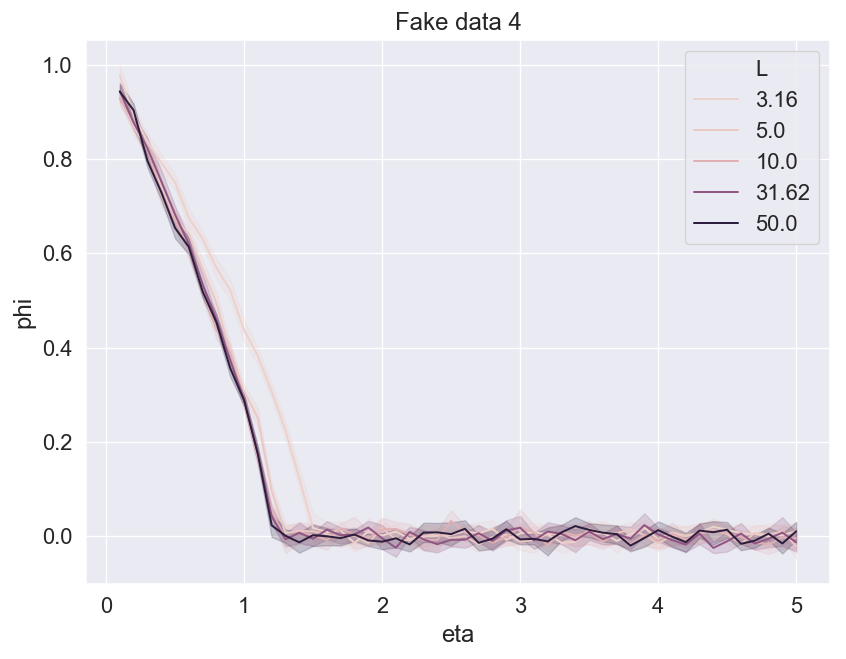

In [125]:
plot_fake_data(4)

# Model 1

In [112]:
model = {}

In [22]:
# Specify Stan model
model["stan_code"] = """
data {
    int<lower=1> nobs;  // number of observations
    real<lower=0> L[nobs];  // observed data
    real<lower=0> eta[nobs];  // observed data
    real<lower=0> phi[nobs];  // observed data
    
    real<lower=0> alpha0; // hyperparameter for eta_c(inf)
    real<lower=0> beta0; // hyperparameter for eta_c(inf) \ 
    real<lower=0> scale0; // hyperparameter for eta_c(inf)
    real<lower=0> k0;  // hyperparameter for critical exponents beta and nu
    real<lower=0> theta0;   // hyperparameter for critical exponents beta and nu
}

parameters {
    real<lower=0> k; // constant factor of eta_c scaling with L
    real<lower=0, upper=1> eta_c_inf_raw; // unscaled critical eta in infinite size system
    real<lower=0> b; // order parameter critical exponent beta; avoid naming conflict with beta distribution
    real<lower=0> nu; // correlation length critical exponent
    real<lower=0> sigma; // sampling and observation error
}

transformed parameters {
    real<lower=0, upper=5> eta_c_inf; // scaled critical eta in infinite size system
    eta_c_inf = scale0 * eta_c_inf_raw;
}

model {
    // Intermediate quantities
    vector[nobs] phi0;
    vector[nobs] eta_c_L;
    
    // Priors
    // k ~ uninformative uniform prior (default in stan)
    eta_c_inf_raw ~ beta(alpha0, beta0);
    b ~ gamma(k0, 1/theta0);
    nu ~ gamma(k0, 1/theta0);
    sigma ~ gamma(2, 1/0.025);
    
    // Likelihoood
    for (n in 1:nobs) {
        eta_c_L[n] = eta_c_inf + k * L[n]^(-1/nu);
        phi0[n] = eta[n] <= eta_c_L[n] ? 
            ((eta_c_L[n] - eta[n])/(eta_c_L[n]))^b : 0;
    }
    phi ~ normal(phi0, sigma);
}
"""

In [23]:
# Compile Stan model
model["stan_model"] = pystan.StanModel(model_code=model["stan_code"])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47c2a5fa0494149590324da9a4160e97 NOW.


In [24]:
# Gather input data for Stan model
model["input"] = {
    'nobs': len(df),
    'L': np.array(df.L),
    'eta': np.array(df.eta),
    'phi': np.array(df.phi),
    
    'alpha0': 1.5,
    'beta0': 1.5,
    'scale0': 5.,
    'k0': 2.,
    'theta0': 0.5,
}

In [25]:
# Sample from posterior
model["output"] =model["stan_model"].sampling(data=model["input"])

In [26]:
# Extract samples and print summary
model["post_samples"] = model["output"].extract()
print model["output"].stansummary()

Inference for Stan model: anon_model_47c2a5fa0494149590324da9a4160e97.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
k               4.26    0.01    0.2   3.89   4.13   4.25   4.37   4.73  212.0   1.03
eta_c_inf_raw   0.37  3.7e-3   0.05   0.25   0.35   0.38   0.41   0.48  194.0   1.03
b               0.61  1.8e-4 4.3e-3    0.6    0.6   0.61   0.61   0.62  539.0   1.01
nu              4.16    0.03   0.48   3.18   3.86   4.13   4.43   5.25  194.0   1.03
sigma           0.06  2.7e-5 9.4e-4   0.06   0.06   0.06   0.07   0.07 1226.0    1.0
eta_c_inf       1.87    0.02   0.26   1.27   1.73   1.89   2.04    2.4  194.0   1.03
lp__          5583.3     0.1   1.88 5578.6 5582.3 5583.7 5584.7 5585.7  365.0   1.01

Samples were drawn using NUTS at Thu Dec 20 13:18:03 2018.
For each parameter, n_eff is a crude measure of effective sample size,


In [103]:
def plot_pairwise(samples, params, start_index=0, end_index=4000):
    # Pick given parameters
    pd_dict = {name: samples[name][start_index:end_index] for name in params}
    # Construct pd.DataFrame for plotting purpose
    samples_df = pd.DataFrame(pd_dict)
    sns.pairplot(data=samples_df)

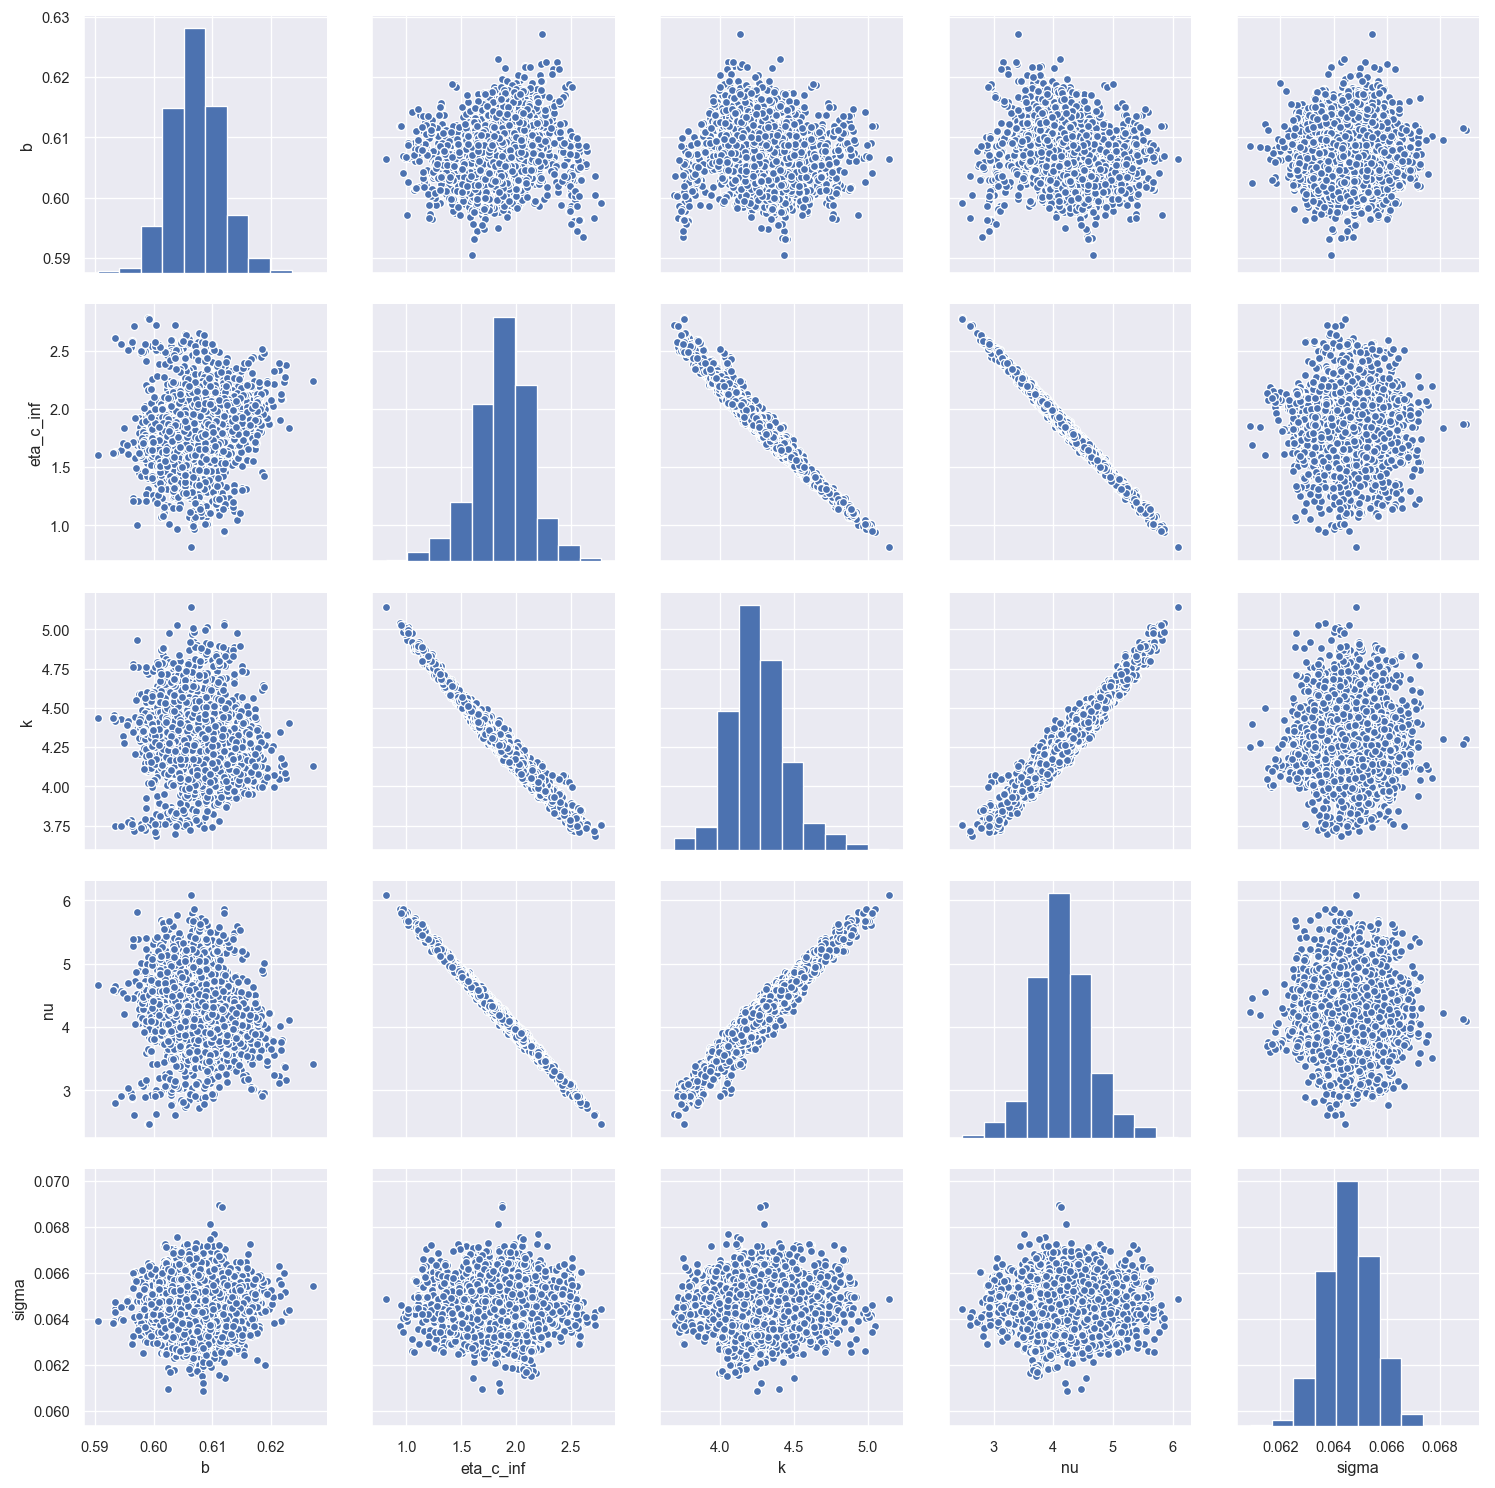

In [101]:
sns.set_context("paper", font_scale=1.)
plot_pairwise(model["post_samples"], ["k", "eta_c_inf", "b", "nu", "sigma"])
plt.savefig("model1_pairwise.png")
plt.show()
sns.set_context("paper", font_scale=1.5)

In [114]:
def plot_inference(df, samples):
    # Original data + (num of samples)*(num of eta)*(num of L)
    total_rows = len(df) + 4000*50*6
    etas = np.zeros(total_rows)
    phis = np.zeros(total_rows)
    Ls = np.zeros(total_rows).astype(str)
    labels = np.zeros(total_rows).astype(str)
    labels[:4000*50*6] = "inference"
    count = 0
    # Obtain phi for each set of parameters in Stan posterior samples
    for L_count,L in enumerate(df["L"].unique()):
        Ls[L_count*4000*50:(L_count+1)*4000*50] = str(round(L,2))
        for i in range(4000):
            k = samples["k"][i]
            eta_c_inf = samples["eta_c_inf"][i]
            beta = samples["b"][i]
            nu = samples["nu"][i]
            sigma = samples["sigma"][i]
            eta_c_L = eta_c_inf + k * L**(-1./nu)
            for eta in np.linspace(0.1, 5.0, 50):
                if eta_c_L - eta > 0:
                    phi0 = ((eta_c_L - eta)/eta_c_L)**beta
                else:
                    phi0 = 0
                etas[count] = eta
                phis[count] = phi0
                count += 1
    # The case when L=infinity
    Ls[(L_count+1)*4000*50:4000*50*6] = u"$\infty$"
    for i in range(4000):
        k = samples["k"][i]
        eta_c_inf = samples["eta_c_inf"][i]
        beta = samples["b"][i]
        nu = samples["nu"][i]
        sigma = samples["sigma"][i]
        eta_c_L = eta_c_inf
        for eta in np.linspace(0.1, 5.0, 50):
            if eta_c_L - eta > 0:
                phi0 = ((eta_c_L - eta)/eta_c_L)**beta
            else:
                phi0 = 0
            etas[count] = eta
            phis[count] = phi0
            count += 1  
    # Placing data in the same DataFrame
    etas[4000*50*6:] = df["eta"]
    phis[4000*50*6:] = df["phi"]
    Ls[4000*50*6:] = df["L"].round(2)
    labels[4000*50*6:] = "data"
    Ls[:] = np.core.defchararray.add("L=", Ls)
    plot_df = pd.DataFrame({"phi": phis, "eta": etas, "label": labels, "L":Ls})
    
    plt.figure()
    ax = sns.lineplot(x="eta", y="phi", hue="L", style="label", data=plot_df)
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[1:7]+handles[8:]
    labels = labels[1:7]+labels[8:]
    ax.legend(handles=handles, labels=labels)
    plt.title("Data vs. inferred curves")
    plt.savefig("inference.png")
    plt.show()

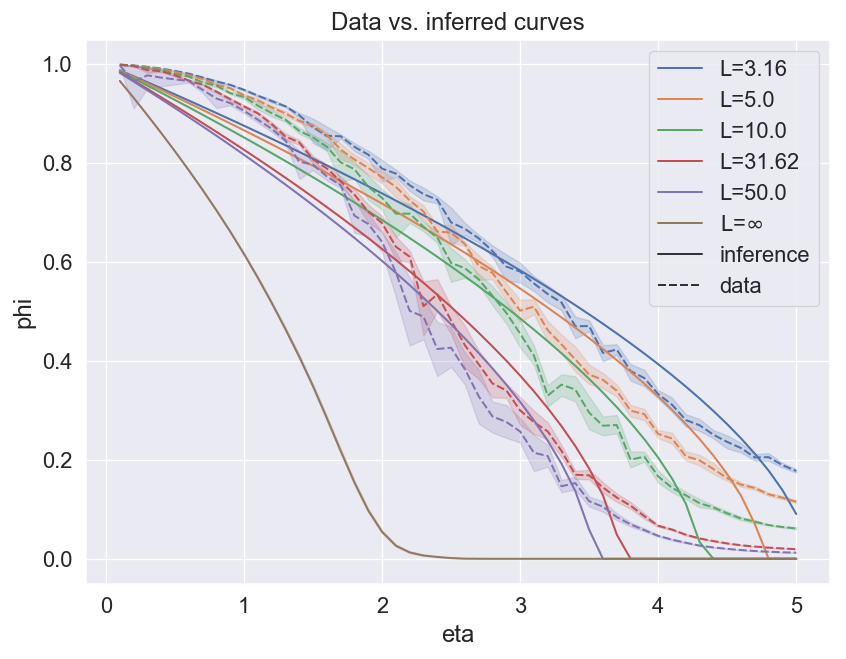

In [115]:
plot_inference(df, model["post_samples"])

In [46]:
def plot_predictions(df, samples, n=5):
    for L in df["L"].unique():
        # Choose three random posterior samples
        random_indices = np.random.choice(np.arange(4000), size=n)
        df[df.L==L]
        etas = np.zeros(500+n*500)
        phis = np.zeros(500+n*500)
        labels = np.zeros(500+n*500).astype(str)
        # Place the data in the same DataFrame for plotting purpose
        etas[:500] = df[df.L==L]["eta"]
        phis[:500] = df[df.L==L]["phi"]
        labels[:500] = "observed data"
        count = 500
        # For each posterior sample
        for predcount, i in enumerate(random_indices):
            # Obtain parameters from the sample
            k = samples["k"][i]
            eta_c_inf = samples["eta_c_inf"][i]
            beta = samples["b"][i]
            nu = samples["nu"][i]
            sigma = samples["sigma"][i]
            eta_c_L = eta_c_inf + k * L**(-1./nu)
            
            labels[count:count+500] = "prediction " + str(predcount+1)
            # For each eta (x-axis)
            for eta in np.linspace(0.1, 5.0, 50):
                if eta_c_L - eta > 0:
                    phi0 = ((eta_c_L - eta)/eta_c_L)**beta
                else:
                    phi0 = 0
                # Imitate 10 trials
                for each_trial in range(10):
                    etas[count] = eta
                    phis[count] = sts.norm.rvs(phi0, sigma)
                    count += 1
        plot_df = pd.DataFrame({"phi": phis, "eta": etas, "label": labels})
        plt.figure()
        ax = sns.lineplot(x="eta", y="phi", hue="label", data=plot_df)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
        plt.title("Randomly Generated Predictions (L={})".format(round(L,1)))
        plt.savefig("predictions_L{}.png".format(round(L,1)))
        plt.show()

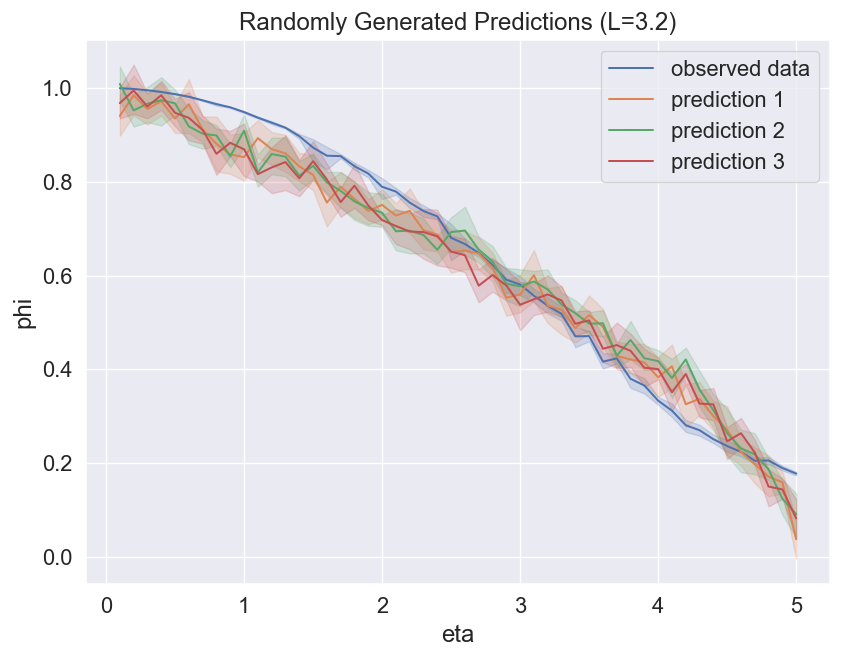

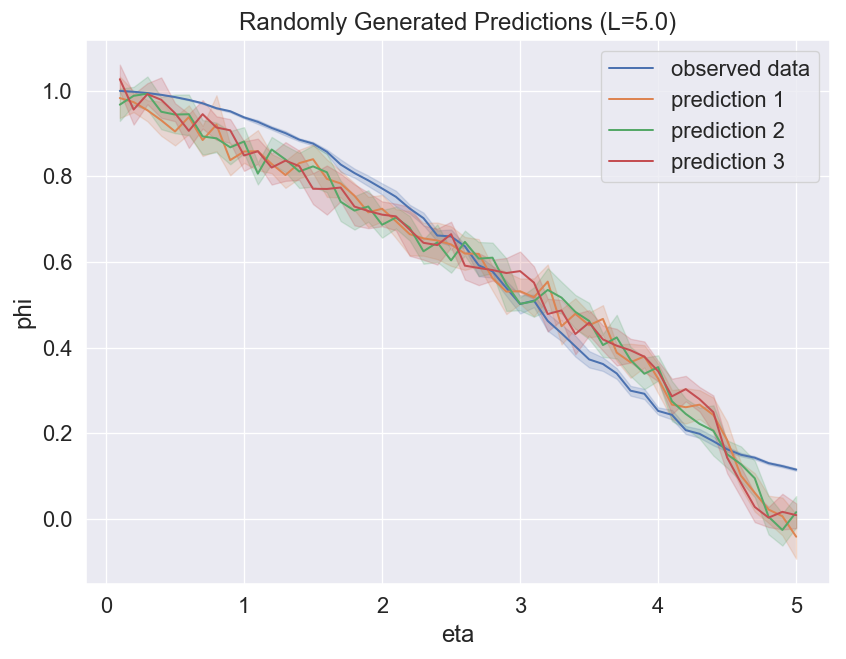

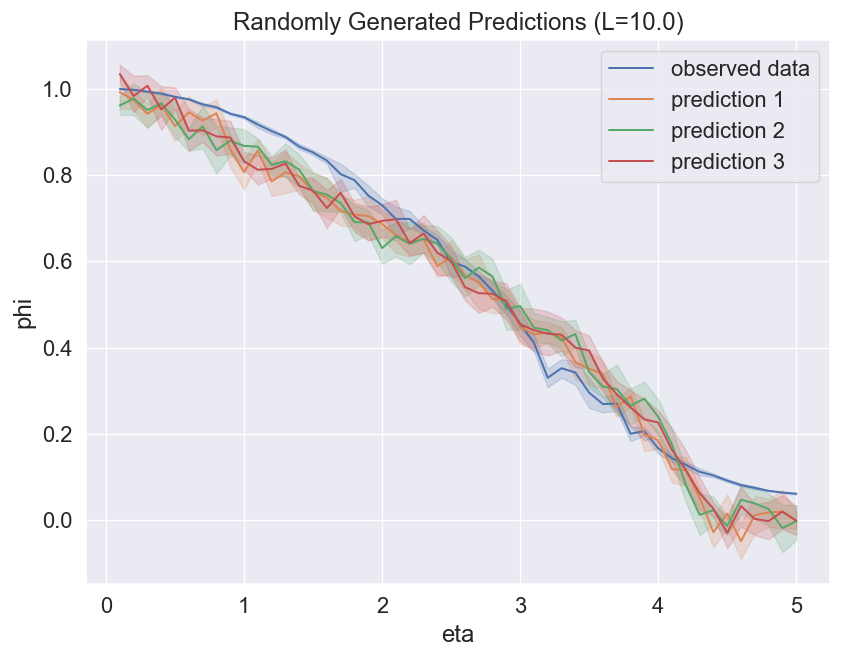

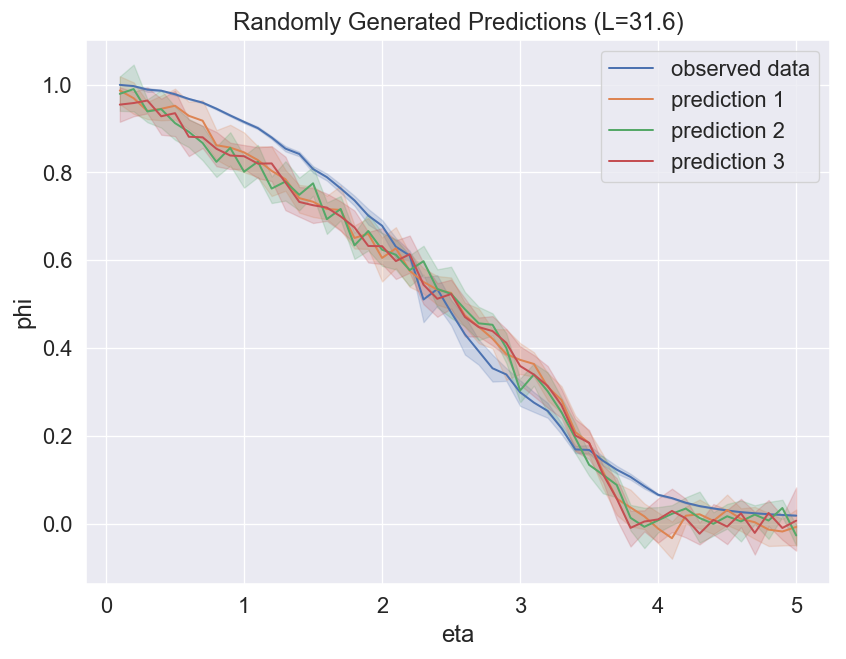

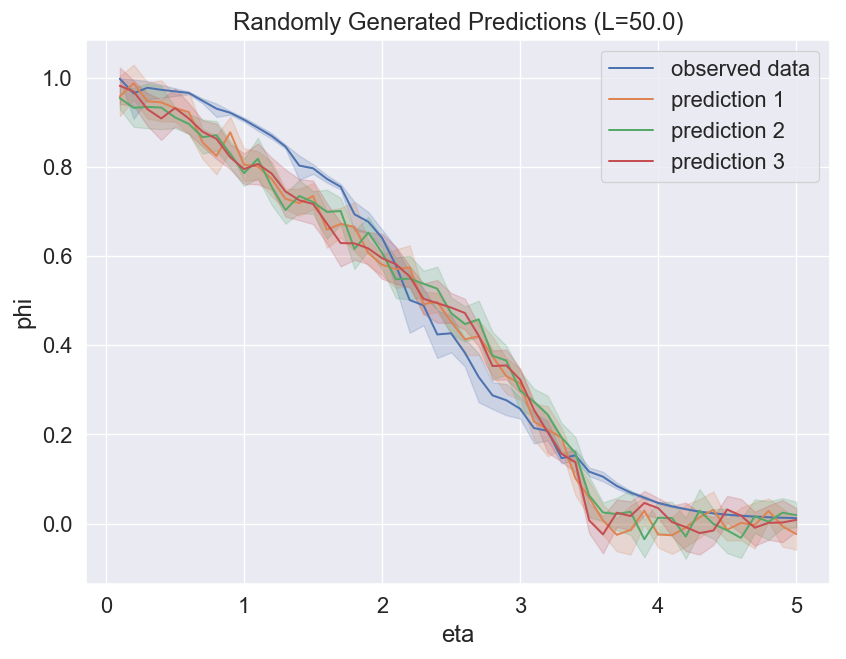

In [47]:
plot_predictions(df, model["post_samples"], n=3)